# Introducción a la Ciencia de Datos: Tarea 2

Este notebook contiene el código de base para realizar la Tarea 2 del curso. Puede copiarlo en su propio repositorio y trabajar sobre el mismo.
Las **instrucciones para ejecutar el notebook** están en la [página inicial del repositorio](https://gitlab.fing.edu.uy/maestria-cdaa/intro-cd/).

**Se espera que no sea necesario revisar el código para corregir la tarea**, ya que todos los resultados y análisis relevantes deberían estar en el **informe en formato PDF**.

## Cargar dependencias
Para esta tarea, se han agregado algunos requerimientos, asegúrese de instalarlos (puede usar el mismo entorno virtual de la Tarea 1):

In [1]:
!pip install jupyter pandas "sqlalchemy<2.0" pymysql seaborn pillow scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.4 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.31
    Uninstalling SQLAlchemy-2.0.31:
      Successfully uninstalled SQLAlchemy-2.0.31
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.52 which is incompatible.


In [2]:
from time import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

## Conexión a la Base y Lectura de Datos

In [3]:
# Conecto con Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path="./data"
#path = "/content/drive/Shared drives"
#path = "/content/drive/My Drive/data"

#path = "/content/drive/My Drive/Maestría/IntroDC/data"

In [5]:
# DataFrame con todas las obras:
df_works = pd.read_csv(path+'/shakespeare/works.csv')

# Todos los párrafos de todas las obras
df_paragraphs = pd.read_csv(path+'/shakespeare/paragraphs.csv')

# Todos los párrafos de todas las obras
df_characters = pd.read_csv(path+'/shakespeare/characters.csv')

# Todos los párrafos de todas las obras
df_chapters = pd.read_csv(path+'/shakespeare/chapters.csv')

In [ ]:
df_paragraphs

,Unnamed: 0,id,ParagraphNum,PlainText,character_id,chapter_id
0,0,630863,3,"[Enter DUKE ORSINO, CURIO, and other Lords; Mu...",1261,18704
1,1,630864,4,"If music be the food of love, play on;\nGive m...",840,18704
2,2,630865,19,"Will you go hunt, my lord?",297,18704
3,3,630866,20,"What, Curio?",840,18704
4,4,630867,21,The hart.,297,18704
...,...,...,...,...,...,...
35460,35460,666323,3460,"That she is living,\nWere it but told you, sho...",866,19648
35461,35461,666324,3467,"You gods, look down\nAnd from your sacred vial...",584,19648
35462,35462,666325,3475,There's time enough for that;\nLest they desir...,866,19648
35463,35463,666326,3483,"O, peace, Paulina!\nThou shouldst a husband ta...",667,19648


## Limpieza de Texto

In [60]:
def clean_text(df, column_name):
    # Convertir todo a minúsculas
    result = df[column_name].str.lower()

    # Quitar signos de puntuación y cambiarlos por espacios (" ")
    for punc in ["[", "\n", ",", ";", ".", "]", "?", ":", "!", "'", "-", "(", ")", "&", "\"", "\t"]:
        result = result.str.replace(punc, " ")
    return result

# Creamos una nueva columna CleanText a partir de PlainText
df_paragraphs["CleanText"] = clean_text(df_paragraphs, "PlainText")

# Veamos la diferencia
df_paragraphs[["PlainText", "CleanText"]]

,PlainText,CleanText
0,"[Enter DUKE ORSINO, CURIO, and other Lords; Mu...",enter duke orsino curio and other lords mu...
1,"If music be the food of love, play on;\nGive m...",if music be the food of love play on give me...
2,"Will you go hunt, my lord?",will you go hunt my lord
3,"What, Curio?",what curio
4,The hart.,the hart
...,...,...
35460,"That she is living,\nWere it but told you, sho...",that she is living were it but told you shou...
35461,"You gods, look down\nAnd from your sacred vial...",you gods look down and from your sacred vials...
35462,There's time enough for that;\nLest they desir...,there s time enough for that lest they desire...
35463,"O, peace, Paulina!\nThou shouldst a husband ta...",o peace paulina thou shouldst a husband tak...


In [200]:
# Agregamos personajes, obras y géneros en el mismo dataset
df_dataset = df_paragraphs.merge(df_chapters.set_index("id")["work_id"], left_on="chapter_id", right_index=True)
df_dataset = df_dataset.merge(df_works.set_index("id")[["Title", "GenreType"]], left_on="work_id", right_index=True)
df_dataset = df_dataset.merge(df_characters.set_index('id')["CharName"], left_on="character_id", right_index=True).sort_index()
df_dataset = df_dataset[["CleanText", "CharName", "Title", "GenreType"]]

# Usaremos sólo estos personajes
#characters = ["Antony", "Cleopatra", "Queen Margaret"]
#characters = ["Poet", "Cleopatra", "Queen Margaret"] # Parte 2.5, sustituye Antony por Henry IV
characters = ['Vincentio', 'Henry VI', 'Brutus'] # Personajes que alcanzaron mayor test accuracy en naive bayes.
df_dataset = df_dataset[df_dataset["CharName"].isin(characters)]

df_dataset

,CleanText,CharName,Title,GenreType
11478,uncles of gloucester and of winchester the sp...,Henry VI,"Henry VI, Part I",History
11483,we charge you on allegiance to ourself to ho...,Henry VI,"Henry VI, Part I",History
11492,o how this discord doth afflict my soul can ...,Henry VI,"Henry VI, Part I",History
11498,fie uncle beaufort i have heard you preach t...,Henry VI,"Henry VI, Part I",History
11503,o loving uncle kind duke of gloucester how ...,Henry VI,"Henry VI, Part I",History
...,...,...,...,...
29877,where is that damned villain tranio that fac...,Vincentio,Taming of the Shrew,Comedy
29881,i ll slit the villain s nose that would have s...,Vincentio,Taming of the Shrew,Comedy
29883,fear not baptista we will content you go to...,Vincentio,Taming of the Shrew,Comedy
29926,ay mistress bride hath that awakened you,Vincentio,Taming of the Shrew,Comedy


In [201]:
# Párrafos por cada personaje seleccionado
df_dataset["CharName"].value_counts()

CharName
Vincentio    217
Brutus       194
Henry VI     183
Name: count, dtype: int64

## Dataset y Features de texto

In [202]:
X = df_dataset["CleanText"].to_numpy()
y = df_dataset["CharName"].to_numpy()

In [203]:

# Realizamos un corte estratificado por el label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Tamaños de Train/Test: {len(X_train)}/{len(X_test)}")

Tamaños de Train/Test: 415/179


In [204]:

## Parte 1.2
## Mostramos cantidad de párrafos por personaje, tanto de train como test.

# Contabilizo personajes en train y test.

count_train = {}
count_test = {}

for y in y_train:
    if y not in count_train:
        count_train[y] = 0
    count_train[y] += 1

for y in y_test:
    if y not in count_test:
        count_test[y] = 0
    count_test[y] += 1

In [206]:
count_train

{'Henry VI': 128, 'Brutus': 135, 'Vincentio': 152}

In [207]:
count_test

{'Vincentio': 65, 'Henry VI': 55, 'Brutus': 59}

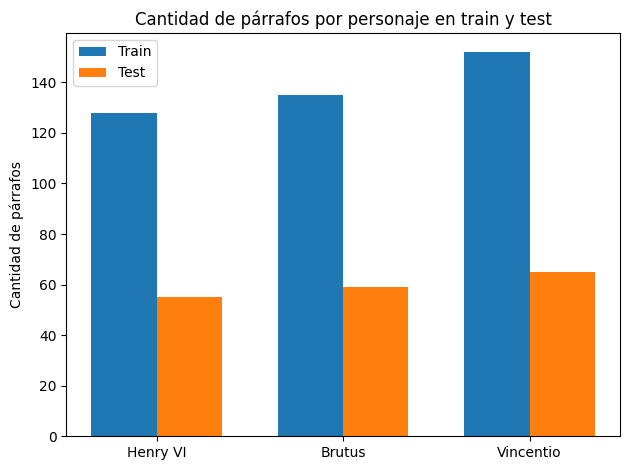

In [205]:
# Genero datos para graficar
labels = [ x for x in count_train ]
len_train_values = [ count_train[x] for x in labels ]
len_test_values = [ count_test[x] for x in labels ]

x = np.arange(3)  # the label locations
width = 0.35  # the width of the bars

# Plot
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, len_train_values, width, label="Train")
rects2 = ax.bar(x + width/2, len_test_values, width, label="Test")

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Cantidad de párrafos')
ax.set_title('Cantidad de párrafos por personaje en train y test')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

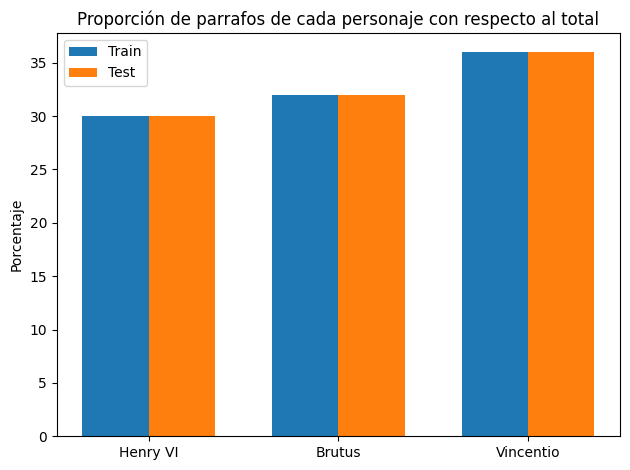

In [208]:
# Genero datos para graficar
labels = [ x for x in count_train ]
len_train_values = [ count_train[x] for x in labels ]
divisor_train=sum(len_train_values)/100
len_train_prop= [x//divisor_train for x in len_train_values]

len_test_values = [ count_test[x] for x in labels ]
divisor_test=sum(len_test_values)/100
len_test_prop= [x//divisor_test for x in len_test_values]

x = np.arange(3)  # the label locations
width = 0.35  # the width of the bars

# Plot
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, len_train_prop, width, label="Train")
rects2 = ax.bar(x + width/2, len_test_prop, width, label="Test")

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Porcentaje')
ax.set_title('Proporción de parrafos de cada personaje con respecto al total')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

### Conteo de palabras y TF-IDF

In [209]:

# Parámetros originales.
#count_vect = CountVectorizer(stop_words=None, ngram_range=(1,1))

# Parámetros con la sugerencia de la letra.
#count_vect = CountVectorizer(stop_words='english', ngram_range=(1,2))

# Parte 2.3, mejor configuración en cross-validation
count_vect = CountVectorizer(stop_words='english', ngram_range=(1,1))

X_train_counts = count_vect.fit_transform(X_train)
X_train_counts


<415x2432 sparse matrix of type '<class 'numpy.int64'>'
	with 5557 stored elements in Compressed Sparse Row format>

In [210]:

# Parámetros originales.
#tf_idf = TfidfTransformer(use_idf=False)

# Parámetros con la sugerencia de la letra.
# También mejor configuración en cross-validation, Parte 2.3
tf_idf = TfidfTransformer(use_idf=True)

X_train_tf = tf_idf.fit_transform(X_train_counts)
X_train_tf

<415x2432 sparse matrix of type '<class 'numpy.float64'>'
	with 5557 stored elements in Compressed Sparse Row format>

### Reducción de dimensionalidad

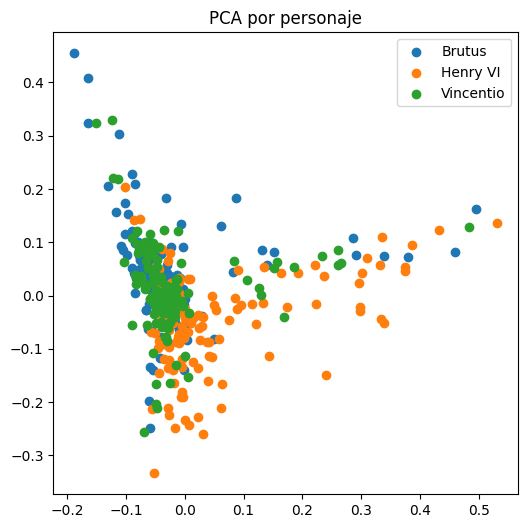

In [211]:

## Aplicamos PCA al resultado de tf-idf

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfTransformer

reductor = PCA(n_components=2)

# Transformar train
X_train_red = reductor.fit_transform(X_train_tf.toarray())

# Visualización de las dos primeras componentes de PCA
fig, ax = plt.subplots(figsize=(6, 6))
for character in np.unique(y_train):
    mask_train = y_train == character
    ax.scatter(X_train_red[mask_train, 0], X_train_red[mask_train, 1], label=character)

ax.set_title("PCA por personaje")
ax.legend()


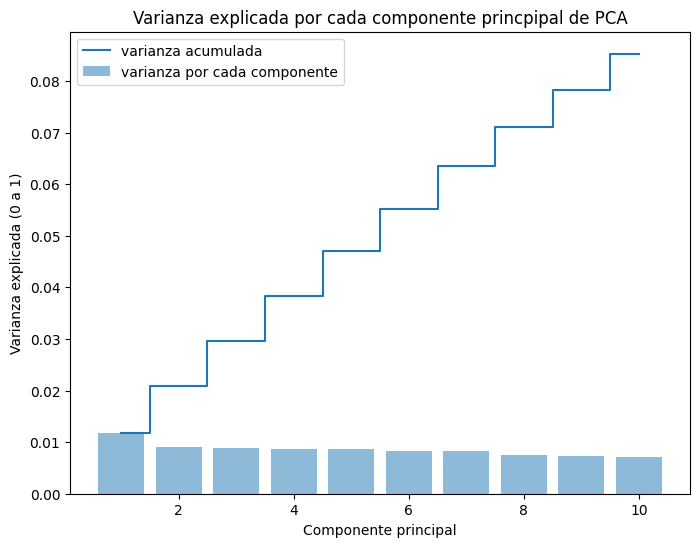

In [212]:

 # Varianza explicada PCA para tf-idf con más componentes.

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_train_tf.toarray())

explained_variance = pca.explained_variance_ratio_

# Graficamos la varianza
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center',
        label='varianza por cada componente')
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid',
         label='varianza acumulada')
plt.ylabel('Varianza explicada (0 a 1)')
plt.xlabel('Componente principal')
plt.legend(loc='best')
plt.title('Varianza explicada por cada componente princpipal de PCA')
plt.show()



# Parte 2

## Modelos de Clasificación

In [213]:
bayes_clf = MultinomialNB().fit(X_train_tf, y_train)

# Ver las primeras 10 predicciones de train
y_pred_train = bayes_clf.predict(X_train_tf)
y_pred_train[:10]

array(['Henry VI', 'Brutus', 'Henry VI', 'Brutus', 'Vincentio',
       'Henry VI', 'Vincentio', 'Henry VI', 'Henry VI', 'Vincentio'],
      dtype='<U9')

In [214]:
def get_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum() / len(y_true)

get_accuracy(y_train, y_pred_train)

0.9855421686746988

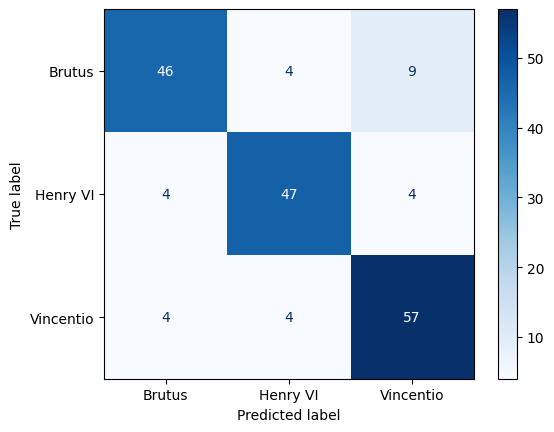

Test Accuracy: 0.8379888268156425
Class Henry VI:
  Precision: 0.8545454545454545
  Recall: 0.8545454545454545
  F-score: 0.8545454545454545
Class Vincentio:
  Precision: 0.8142857142857143
  Recall: 0.8769230769230769
  F-score: 0.8444444444444444
Class Brutus:
  Precision: 0.8518518518518519
  Recall: 0.7796610169491526
  F-score: 0.8141592920353983


In [215]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

# Aplico transformaciones para test.
# Solo transformaciones, no realizo ningun entrenamiento ya que es test.

X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tf_idf.transform(X_test_counts)
y_test_pred = bayes_clf.predict(X_test_tfidf)

# Calculo matriz de confusion y accuracy
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, cmap=plt.cm.Blues)
plt.show()

print("Test Accuracy: "+str(get_accuracy(y_test, y_test_pred)))

# Muestro precision, recall y f1
labels = list(set(y_test))
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_test_pred, labels=labels)
for i, label in enumerate(labels):
    print(f"Class {label}:")
    print(f"  Precision: {precision[i]}")
    print(f"  Recall: {recall[i]}")
    print(f"  F-score: {fscore[i]}")


### Búsqueda de hiper-parámetros con Cross-Validation

In [98]:
from sklearn.model_selection import StratifiedKFold

# Conjunto de hiper-parámetros para probar con cross-validation
param_sets = [{"stop_words": None, "ngram": (1,2), "idf": True},
             {"stop_words": None, "ngram": (1,1), "idf": False},
              {"stop_words": 'english', "ngram": (1,1), "idf": False},
              {"stop_words": 'english', "ngram": (1,1), "idf": True},
              {"stop_words": 'english', "ngram": (1,2), "idf": False},
              {"stop_words": 'english', "ngram": (1,2), "idf": True},
              {"stop_words": 'english', "ngram": (1,3), "idf": True},]

k_fold = 4
skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=42)

# Ahora usaremos train/validation/test
# Por lo tanto le renombramos train+validation = dev(elopment) dataset
X_dev = X_train
y_dev = y_train

# # Para evitar errores
# del X_train
# del y_train

scores_for_plot = {}

for index, params in enumerate(param_sets):

    scores_for_plot[index] = []

    # Transormaciones a aplicar (featurizers)
    count_vect = CountVectorizer(stop_words=params["stop_words"], ngram_range=params["ngram"])
    tf_idf = TfidfTransformer(use_idf=params["idf"])

    media = 0
    for train_idxs, val_idxs in skf.split(X_dev, y_dev):

        # Train y validation para el split actual
        X_train_ = X_dev[train_idxs]
        y_train_ = y_dev[train_idxs]
        X_val = X_dev[val_idxs]
        y_val = y_dev[val_idxs]

        # Ajustamos y transformamos Train
        X_train_counts = count_vect.fit_transform(X_train_)
        X_train_tf = tf_idf.fit_transform(X_train_counts)

        # Entrenamos con Train
        bayes_clf = MultinomialNB().fit(X_train_tf, y_train_)

        # Transformamos Validation
        X_val_counts = count_vect.transform(X_val)
        X_val_tfidf = tf_idf.transform(X_val_counts)

        # Predecimos y evaluamos en Validation
        y_pred_val = bayes_clf.predict(X_val_tfidf)
        acc = get_accuracy(y_val, y_pred_val)
        #print(f"{acc=:.4f} {params=}")

        scores_for_plot[index].append(acc)

        media += acc

    media /= k_fold
    print(f"{media=:.4f} {params=}")
    print("")


media=0.6725 params={'stop_words': None, 'ngram': (1, 2), 'idf': True}

media=0.6738 params={'stop_words': None, 'ngram': (1, 1), 'idf': False}

media=0.6800 params={'stop_words': 'english', 'ngram': (1, 1), 'idf': False}

media=0.6851 params={'stop_words': 'english', 'ngram': (1, 1), 'idf': True}

media=0.6763 params={'stop_words': 'english', 'ngram': (1, 2), 'idf': False}

media=0.6763 params={'stop_words': 'english', 'ngram': (1, 2), 'idf': True}

media=0.6763 params={'stop_words': 'english', 'ngram': (1, 3), 'idf': True}



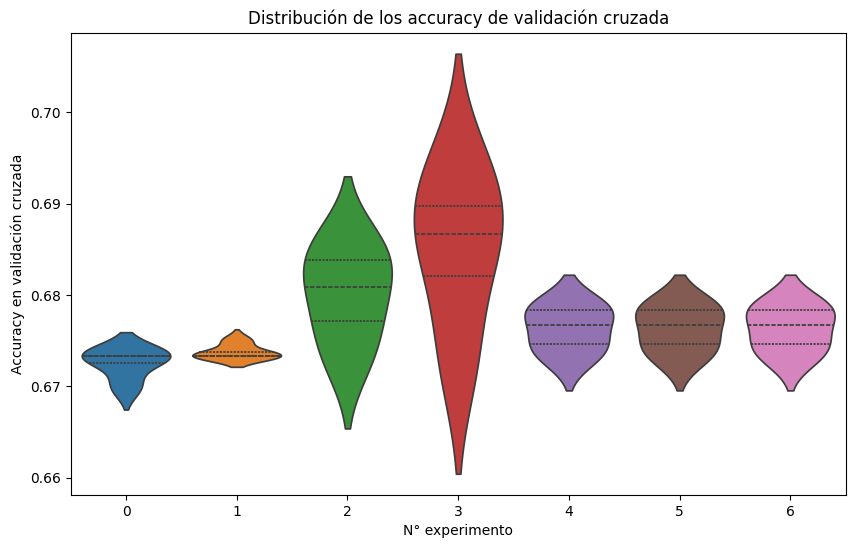

In [99]:
import seaborn as sns

# Gráfico de violín
plt.figure(figsize=(10, 6))
sns.violinplot(data=scores_for_plot, inner="quartile")
plt.title("Distribución de los accuracy de validación cruzada")
plt.xlabel("N° experimento")
plt.ylabel("Accuracy en validación cruzada")
plt.show()


## Parte 2.4

### SVM

In [173]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold

# Conjunto de hiper-parámetros para probar con cross-validation
param_sets = [{"kernel": "linear", "stop_words": None, "ngram": (1,2), "idf": True},
             {"kernel": "linear", "stop_words": None, "ngram": (1,1), "idf": False},
              {"kernel": "linear", "stop_words": 'english', "ngram": (1,1), "idf": False},
              {"kernel": "linear", "stop_words": 'english', "ngram": (1,1), "idf": True},
              {"kernel": "linear", "stop_words": 'english', "ngram": (1,2), "idf": False},
              {"kernel": "linear", "stop_words": 'english', "ngram": (1,2), "idf": True},
              {"kernel": "linear", "stop_words": 'english', "ngram": (1,3), "idf": True},
              {"kernel": "rbf", "stop_words": None, "ngram": (1,2), "idf": True},
             {"kernel": "rbf", "stop_words": None, "ngram": (1,1), "idf": False},
              {"kernel": "rbf", "stop_words": 'english', "ngram": (1,1), "idf": False},
              {"kernel": "rbf", "stop_words": 'english', "ngram": (1,1), "idf": True},
              {"kernel": "rbf", "stop_words": 'english', "ngram": (1,2), "idf": False},
              {"kernel": "rbf", "stop_words": 'english', "ngram": (1,2), "idf": True},
              {"kernel": "rbf", "stop_words": 'english', "ngram": (1,3), "idf": True},
              {"kernel": "poly", "stop_words": None, "ngram": (1,2), "idf": True},
             {"kernel": "poly", "stop_words": None, "ngram": (1,1), "idf": False},
              {"kernel": "poly", "stop_words": 'english', "ngram": (1,1), "idf": False},
              {"kernel": "poly", "stop_words": 'english', "ngram": (1,1), "idf": True},
              {"kernel": "poly", "stop_words": 'english', "ngram": (1,2), "idf": False},
              {"kernel": "poly", "stop_words": 'english', "ngram": (1,2), "idf": True},
              {"kernel": "poly", "stop_words": 'english', "ngram": (1,3), "idf": True},]

k_fold = 4
skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=42)

# Ahora usaremos train/validation/test
# Por lo tanto le renombramos train+validation = dev(elopment) dataset
X_dev = X_train
y_dev = y_train

# # Para evitar errores
# del X_train
# del y_train

scores_for_plot = {}

for index, params in enumerate(param_sets):

    scores_for_plot[index] = []

    # Transormaciones a aplicar (featurizers)
    count_vect = CountVectorizer(stop_words=params["stop_words"], ngram_range=params["ngram"])
    tf_idf = TfidfTransformer(use_idf=params["idf"])

    media = 0
    for train_idxs, val_idxs in skf.split(X_dev, y_dev):

        # Train y validation para el split actual
        X_train_ = X_dev[train_idxs]
        y_train_ = y_dev[train_idxs]
        X_val = X_dev[val_idxs]
        y_val = y_dev[val_idxs]

        # Ajustamos y transformamos Train
        X_train_counts = count_vect.fit_transform(X_train_)
        X_train_tf = tf_idf.fit_transform(X_train_counts)

        # Entrenamos con Train
        svm_clf = SVC(kernel=params['kernel']).fit(X_train_tf, y_train_)

        # Transformamos Validation
        X_val_counts = count_vect.transform(X_val)
        X_val_tfidf = tf_idf.transform(X_val_counts)

        # Predecimos y evaluamos en Validation
        y_pred_val = svm_clf.predict(X_val_tfidf)
        acc = get_accuracy(y_val, y_pred_val)
        #print(f"{acc=:.4f} {params=}")

        scores_for_plot[index].append(acc)

        media += acc

    media /= k_fold
    print(f"{media=:.4f} {params=}")
    print("")


media=0.5823 params={'kernel': 'linear', 'stop_words': None, 'ngram': (1, 2), 'idf': True}

media=0.5526 params={'kernel': 'linear', 'stop_words': None, 'ngram': (1, 1), 'idf': False}

media=0.6461 params={'kernel': 'linear', 'stop_words': 'english', 'ngram': (1, 1), 'idf': False}

media=0.6347 params={'kernel': 'linear', 'stop_words': 'english', 'ngram': (1, 1), 'idf': True}

media=0.6484 params={'kernel': 'linear', 'stop_words': 'english', 'ngram': (1, 2), 'idf': False}

media=0.6393 params={'kernel': 'linear', 'stop_words': 'english', 'ngram': (1, 2), 'idf': True}

media=0.6346 params={'kernel': 'linear', 'stop_words': 'english', 'ngram': (1, 3), 'idf': True}

media=0.4338 params={'kernel': 'rbf', 'stop_words': None, 'ngram': (1, 2), 'idf': True}

media=0.5092 params={'kernel': 'rbf', 'stop_words': None, 'ngram': (1, 1), 'idf': False}

media=0.5868 params={'kernel': 'rbf', 'stop_words': 'english', 'ngram': (1, 1), 'idf': False}

media=0.5503 params={'kernel': 'rbf', 'stop_words': 'e

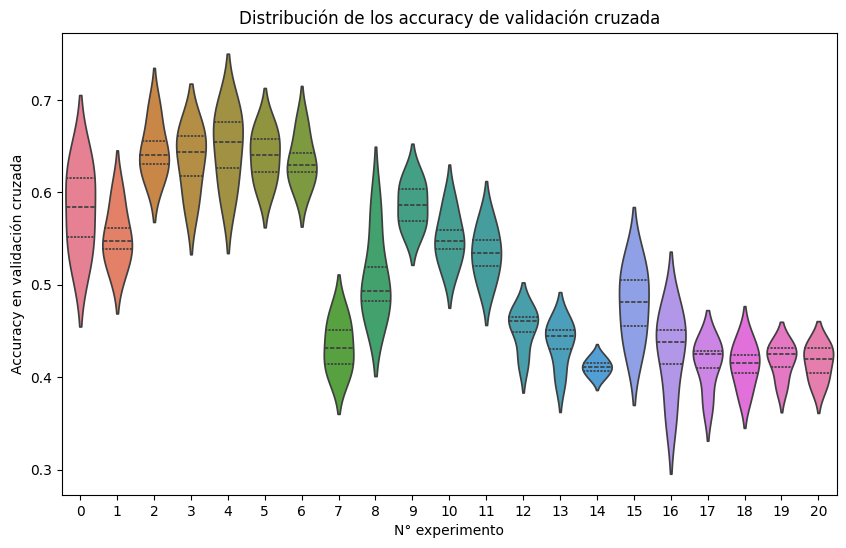

In [174]:
import seaborn as sns

# Gráfico de violín
plt.figure(figsize=(10, 6))
sns.violinplot(data=scores_for_plot, inner="quartile")
plt.title("Distribución de los accuracy de validación cruzada")
plt.xlabel("N° experimento")
plt.ylabel("Accuracy en validación cruzada")
plt.show()


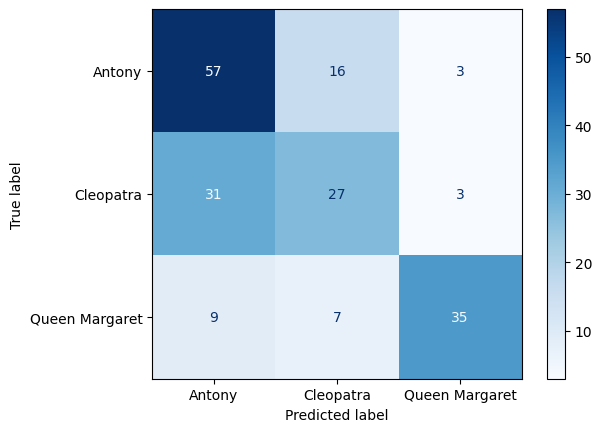

Train Accuracy: 0.9634703196347032
Test Accuracy: 0.6329787234042553
Class Queen Margaret:
  Precision: 0.8536585365853658
  Recall: 0.6862745098039216
  F-score: 0.7608695652173912
Class Cleopatra:
  Precision: 0.54
  Recall: 0.4426229508196721
  F-score: 0.48648648648648646
Class Antony:
  Precision: 0.5876288659793815
  Recall: 0.75
  F-score: 0.6589595375722542


In [175]:

# Los generadores de los features
count_vect = CountVectorizer(stop_words='english', ngram_range=(1,2))
tf_idf = TfidfTransformer(use_idf=False)

# Entreno los generadores de los features y obtengo train
X_train_counts = count_vect.fit_transform(X_train)
X_train_tfidf = tf_idf.fit_transform(X_train_counts)

# Creamos SVM
svm_clf = SVC(kernel='linear')

# Entrenamos el clasificador
svm_clf.fit(X_train_tfidf, y_train)

# Genero features de test
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tf_idf.transform(X_test_counts)

# Realizo predicciones
y_test_pred = svm_clf.predict(X_test_tfidf)

# Calculo matriz de confusion y accuracy
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, cmap=plt.cm.Blues)
plt.show()

print("Train Accuracy: "+str(get_accuracy(y_train, y_pred_train)))
print("Test Accuracy: "+str(get_accuracy(y_test, y_test_pred)))

# Muestro precision, recall y f1
labels = list(set(y_test))
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_test_pred, labels=labels)
for i, label in enumerate(labels):
    print(f"Class {label}:")
    print(f"  Precision: {precision[i]}")
    print(f"  Recall: {recall[i]}")
    print(f"  F-score: {fscore[i]}")


### Parte 2.5: Analisis de los personajes con mayor accuracy

In [31]:

## Buscamos la combinacion de los 3 personajes los cuales tienen un mayor test accuracy para Naive Bayes.

# Agregamos personajes, obras y géneros en el mismo dataset
df_dataset = df_paragraphs.merge(df_chapters.set_index("id")["work_id"], left_on="chapter_id", right_index=True)
df_dataset = df_dataset.merge(df_works.set_index("id")[["Title", "GenreType"]], left_on="work_id", right_index=True)
df_dataset = df_dataset.merge(df_characters.set_index('id')["CharName"], left_on="character_id", right_index=True).sort_index()
df_dataset = df_dataset[["CleanText", "CharName", "Title", "GenreType"]]

# Los primeros 28 personajes que más palabras tienen.
list_of_characters = ['Henry V',
    'Falstaff',
    'Hamlet',
    'Duke of Gloucester',
    'Antony',
    'Iago',
    'Henry IV',
    'Vincentio',
    'Henry VI',
    'Richard III',
    'Queen Margaret',
    'Coriolanus',
    'Timon',
    'Othello',
    'King Richard II',
    'Lear',
    'Rosalind',
    'Titus Andronicus',
    'Earl of Warwick',
    'Macbeth',
    'Brutus',
    'Helena',
    'Portia',
    'Prospero',
    'Leontes',
    'Duke of Buckingham',
    'Biron',
    'Cleopatra']

# Maximo test accuracy encontrado
max_acc = 0

# Construyo la combinacion de personajes.
for i in range(len(list_of_characters)):
    for j in range(i + 1, len(list_of_characters)):
        for k in range(j + 1, len(list_of_characters)):

            # Usaremos sólo estos personajes
            characters = [ list_of_characters[i], list_of_characters[j], list_of_characters[k] ]
            df = df_dataset[df_dataset["CharName"].isin(characters)]

            # Genero features.
            X = df["CleanText"].to_numpy()
            y = df["CharName"].to_numpy()

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

            count_vect = CountVectorizer(stop_words='english', ngram_range=(1,1))
            X_train_counts = count_vect.fit_transform(X_train)
            tf_idf = TfidfTransformer(use_idf=True)
            X_train_tf = tf_idf.fit_transform(X_train_counts)

            # Entreno el modelo
            bayes_clf = MultinomialNB().fit(X_train_tf, y_train)

            # Features de test
            X_test_counts = count_vect.transform(X_test)
            X_test_tfidf = tf_idf.transform(X_test_counts)

            # Realizo predicciones sobre test
            y_test_pred = bayes_clf.predict(X_test_tfidf)

            # Calculo accuracy
            acc = get_accuracy(y_test, y_test_pred)

            # Me quedo con la mayor hasta el momento
            if acc > max_acc:
                max_acc = acc
                print("Test accuracy: "+str(acc))
                print(characters)
                print("")


Test accuracy: 0.5966850828729282
['Henry V', 'Falstaff', 'Hamlet']

Test accuracy: 0.622356495468278
['Henry V', 'Falstaff', 'Antony']

Test accuracy: 0.6232394366197183
['Henry V', 'Falstaff', 'King Richard II']

Test accuracy: 0.7138047138047138
['Henry V', 'Hamlet', 'Antony']

Test accuracy: 0.7211895910780669
['Hamlet', 'Duke of Gloucester', 'Antony']

Test accuracy: 0.7280334728033473
['Hamlet', 'Antony', 'Henry VI']

Test accuracy: 0.7464114832535885
['Duke of Gloucester', 'Vincentio', 'Brutus']

Test accuracy: 0.7551020408163265
['Antony', 'Vincentio', 'Earl of Warwick']

Test accuracy: 0.7714285714285715
['Iago', 'Vincentio', 'Timon']

Test accuracy: 0.8051282051282052
['Iago', 'Henry VI', 'Brutus']

Test accuracy: 0.8115942028985508
['Henry IV', 'Coriolanus', 'Prospero']

Test accuracy: 0.8379888268156425
['Vincentio', 'Henry VI', 'Brutus']



### (Opcional) Comparativa con Fasttext

In [19]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 1.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.1-py3-none-any.whl (238 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4246764 sha256=79edc4c25324c52fc40abe846b8802696b1b12e9ab63f5e296a275b988e98dbb
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext


In [137]:
import fasttext

y_train_s = np.char.replace(y_train.astype(str), " ", "_").astype(object)
y_test_s = np.char.replace(y_test.astype(str), " ", "_").astype(object)

# Convertimos al formato de fasttext: archivo de texto donde cada línea es:
# __label__<label> TEXTO
Xytrains = "__label__" + y_train_s.astype(object) + " " + X_train
Xytests = "__label__" + y_test_s.astype(object) + " " + X_test
np.savetxt(path + "/fasttext/train.txt", Xytrains, fmt="%s")
np.savetxt(path + "/fasttext/test.txt", Xytests, fmt="%s")

Xytests[0]

'__label__Cleopatra for the most part  too  they are foolish that are so  her hair  what colour '

In [138]:
# Ralizamos varios corte de epochs para analizar el accuracy de train y test.

train_accuracies = []
test_accuracies = []

for epoch in range(1, 1000, 50):
    model = fasttext.train_supervised(input=str(path + "/fasttext/train.txt"), epoch=epoch, wordNgrams=2, verbose=2, minCount=1)
    train_accuracy = model.test(str(path + "/fasttext/train.txt"))[1]
    test_accuracy = model.test(str(path + "/fasttext/test.txt"))[1]
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

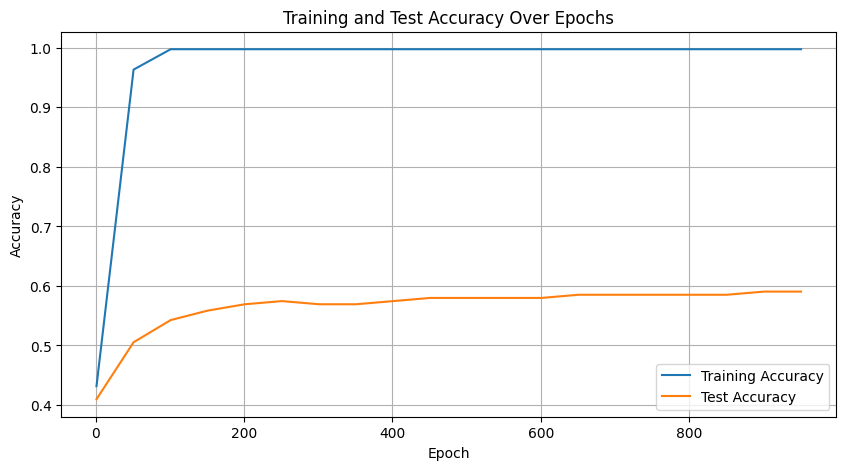

In [139]:
# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, 1000, 50), train_accuracies, label='Training Accuracy')
plt.plot(range(1, 1000, 50), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [140]:
model = fasttext.train_supervised(input=str(path + "/fasttext/train.txt"), epoch=950, wordNgrams=2)
model.test(str(path + "/fasttext/test.txt"))

(188, 0.5904255319148937, 0.5904255319148937)

In [141]:
y_out = model.predict(list(X_test))
y_pred_test = [y[0].replace("__label__", "") for y in y_out[0]]

print("Test Accuracy: "+str(get_accuracy(y_test_s, y_pred_test)))

Test Accuracy: 0.5904255319148937


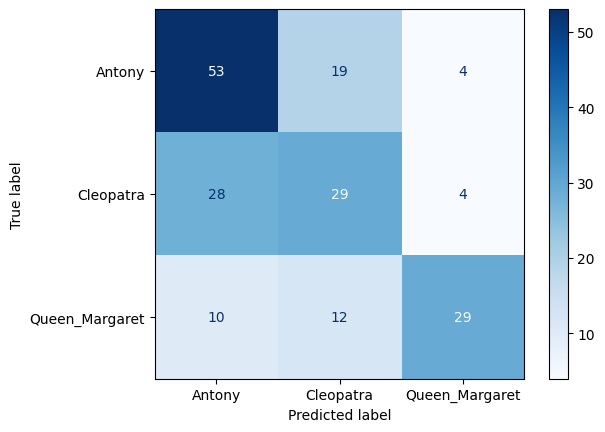

Class Queen_Margaret:
  Precision: 0.7837837837837838
  Recall: 0.5686274509803921
  F-score: 0.6590909090909091
Class Cleopatra:
  Precision: 0.48333333333333334
  Recall: 0.47540983606557374
  F-score: 0.4793388429752066
Class Antony:
  Precision: 0.5824175824175825
  Recall: 0.6973684210526315
  F-score: 0.6347305389221557


In [150]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

labels = list(set(y_test_s))

# Calculo matriz de confusion y accuracy
ConfusionMatrixDisplay.from_predictions(y_test_s, y_pred_test, cmap=plt.cm.Blues)
plt.show()

# Muestro precision, recall y f1
precision, recall, fscore, support = precision_recall_fscore_support(y_test_s, y_pred_test, labels=labels)
for i, label in enumerate(labels):
    print(f"Class {label}:")
    print(f"  Precision: {precision[i]}")
    print(f"  Recall: {recall[i]}")
    print(f"  F-score: {fscore[i]}")
